In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn_pandas import CategoricalImputer
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy import stats
from pprint import pprint
from collections import Counter
from imblearn.over_sampling import SMOTE
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
bank_full = pd.read_csv(r'C:\Users\wangs\Documents\SpringBorad\Project\BANK_MARKETING_DATASET\bank-additional\bank-additional\bank-additional-full.csv', sep = ';', na_values = ['unknown', 'nonexistent'])
print (bank_full.head())

   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school     NaN      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  campaign  pdays  previous  poutcome emp.var.rate  \
0         mon  ...         1    999         0       NaN          1.1   
1         mon  ...         1    999         0       NaN          1.1   
2         mon  ...         1    999         0       NaN          1.1   
3         mon  ...         1    999         0       NaN          1.1   
4         mon  ...         1    999         0       NaN          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to see the most important features for a clinet to subscribe and predict if the client will subscribe a term deposit (variable y).


In [3]:
bank_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        5625 non-null   object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

From the bank_full info, we can see that the dataset has 41,188 row, and 21 columns. Column job, marital, eductaion, default, housing, loan, and poutcome have missing values. 

In [4]:
bank_full.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


The describe data shows a general picture for numeric variables. We can see the that most customers are in the middle ages from 30 – 47 years old.  75% of the phone call duration is below 319 seconds. Most pdays values are 999, which means most client was not previously contacted.Employment variation rate, consumer price index,  consumer confidence index, euribor 3 month rate, and  number of employees are economic related data that reflect the big economic environment. 



In [5]:
#Identify numeric and categorical variables 
total_columns = bank_full.columns
print (total_columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [6]:
num_columns = list(bank_full._get_numeric_data().columns)
print (num_columns)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [7]:
cat_columns = list(set(total_columns) - set(num_columns))
print (cat_columns)

['housing', 'poutcome', 'contact', 'month', 'marital', 'job', 'education', 'day_of_week', 'loan', 'y', 'default']


## Missing Values Imputation

In [8]:
#Find missing value percentage for each column
bank_full.isnull().mean().sort_values(ascending=False)*100

poutcome          86.343110
default           20.872584
education          4.202680
housing            2.403613
loan               2.403613
job                0.801204
marital            0.194231
y                  0.000000
day_of_week        0.000000
contact            0.000000
month              0.000000
duration           0.000000
nr.employed        0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
age                0.000000
dtype: float64

In [9]:
#Find value counts in percentage for pdays column
(bank_full.pdays.value_counts()/bank_full.pdays.count()).sort_index()*100

0       0.036418
1       0.063125
2       0.148101
3       1.065844
4       0.286491
5       0.111683
6       1.000291
7       0.145673
8       0.043702
9       0.155385
10      0.126250
11      0.067981
12      0.140818
13      0.087404
14      0.048558
15      0.058269
16      0.026707
17      0.019423
18      0.016995
19      0.007284
20      0.002428
21      0.004856
22      0.007284
25      0.002428
26      0.002428
27      0.002428
999    96.321744
Name: pdays, dtype: float64

By calculating the percentage of missing values for each column, we can see that 86% of the values in 'poutcoume' (previous outcome) column are missing values.And for pday column, the value of 999 takes up 96% of the rows. We know that 999 means client was not previously contacted. That makes sense because the previous outcome is missing when there is no previous contact. 

In [10]:
bank_full['pdays_cat']=0
bank_full.loc[bank_full['pdays'] <= 5,'pdays_cat'] = '<= 5 days'
bank_full.loc[(bank_full['pdays'] > 5) & (bank_full['pdays']<= 10),'pdays_cat'] = '5-10 days'
bank_full.loc[(bank_full['pdays'] > 10) & (bank_full['pdays']< 999),'pdays_cat'] = '>10 days'
bank_full.loc [bank_full['pdays'] == 999, 'pdays_cat']= 'no contact before'
bank_full['pdays_cat'].unique()
bank_full = bank_full.drop('pdays', axis = 1)
bank_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_cat
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no,no contact before
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no,no contact before
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no,no contact before
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no,no contact before
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no,no contact before


In [11]:
cat_columns.append('pdays_cat')
num_columns.remove('pdays')
print ('Categorical:', cat_columns, '\n', 'Numerical:', num_columns)

Categorical: ['housing', 'poutcome', 'contact', 'month', 'marital', 'job', 'education', 'day_of_week', 'loan', 'y', 'default', 'pdays_cat'] 
 Numerical: ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


To deal with 'pdays' column, a new column 'pday_cat'is created with categorical values based on the condition of 'pdays' column. The coresponding pdays_cat value is assigned as '<= 5 days', '5-10 days', '>10 days' and 'no contact before' if 'pdays' is 999. The origianl 'pdays' column is dropped.

# Apply One-Hot Encoding

In [12]:
imputer = CategoricalImputer()
bank_full[cat_columns] = imputer.fit_transform(bank_full[cat_columns].values)

In [13]:
bankcat = bank_full[cat_columns]
enc = preprocessing.OneHotEncoder(handle_unknown ='ignore')
enc.fit(bankcat)
ohe=enc.transform(bankcat).toarray()
ohe_columns = enc.get_feature_names(cat_columns)
print (ohe_columns)
ohdf = pd.DataFrame(ohe, columns=ohe_columns)
ohdf.head()

['housing_no' 'housing_yes' 'poutcome_failure' 'poutcome_no'
 'poutcome_success' 'contact_cellular' 'contact_telephone' 'month_apr'
 'month_aug' 'month_dec' 'month_jul' 'month_jun' 'month_mar' 'month_may'
 'month_nov' 'month_oct' 'month_sep' 'marital_divorced' 'marital_married'
 'marital_no' 'marital_single' 'job_admin.' 'job_blue-collar'
 'job_entrepreneur' 'job_housemaid' 'job_management' 'job_no'
 'job_retired' 'job_self-employed' 'job_services' 'job_student'
 'job_technician' 'job_unemployed' 'education_basic.4y'
 'education_basic.6y' 'education_basic.9y' 'education_high.school'
 'education_illiterate' 'education_no' 'education_professional.course'
 'education_university.degree' 'day_of_week_fri' 'day_of_week_mon'
 'day_of_week_thu' 'day_of_week_tue' 'day_of_week_wed' 'loan_no'
 'loan_yes' 'y_no' 'y_yes' 'default_no' 'default_yes'
 'pdays_cat_5-10 days' 'pdays_cat_<= 5 days' 'pdays_cat_>10 days'
 'pdays_cat_no contact before']


,housing_no,housing_yes,poutcome_failure,poutcome_no,poutcome_success,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,...,loan_no,loan_yes,y_no,y_yes,default_no,default_yes,pdays_cat_5-10 days,pdays_cat_<= 5 days,pdays_cat_>10 days,pdays_cat_no contact before
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [14]:
imputed_bank_full=pd.concat([bank_full[num_columns], ohdf], axis=1)
imputed_bank_full.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,housing_no,...,loan_no,loan_yes,y_no,y_yes,default_no,default_yes,pdays_cat_5-10 days,pdays_cat_<= 5 days,pdays_cat_>10 days,pdays_cat_no contact before
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Exploratory Data Analysis

Text(0, 0.5, 'Frequency')

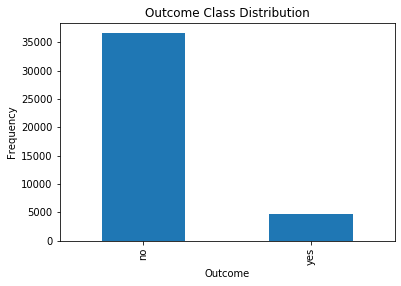

In [36]:
#Plot the outcome 
count_y = pd.value_counts(bank_full.y, sort = True)
count_y.plot(kind= 'bar')
plt.title('Outcome Class Distribution')
plt.xlabel('Outcome')
plt.ylabel('Frequency')

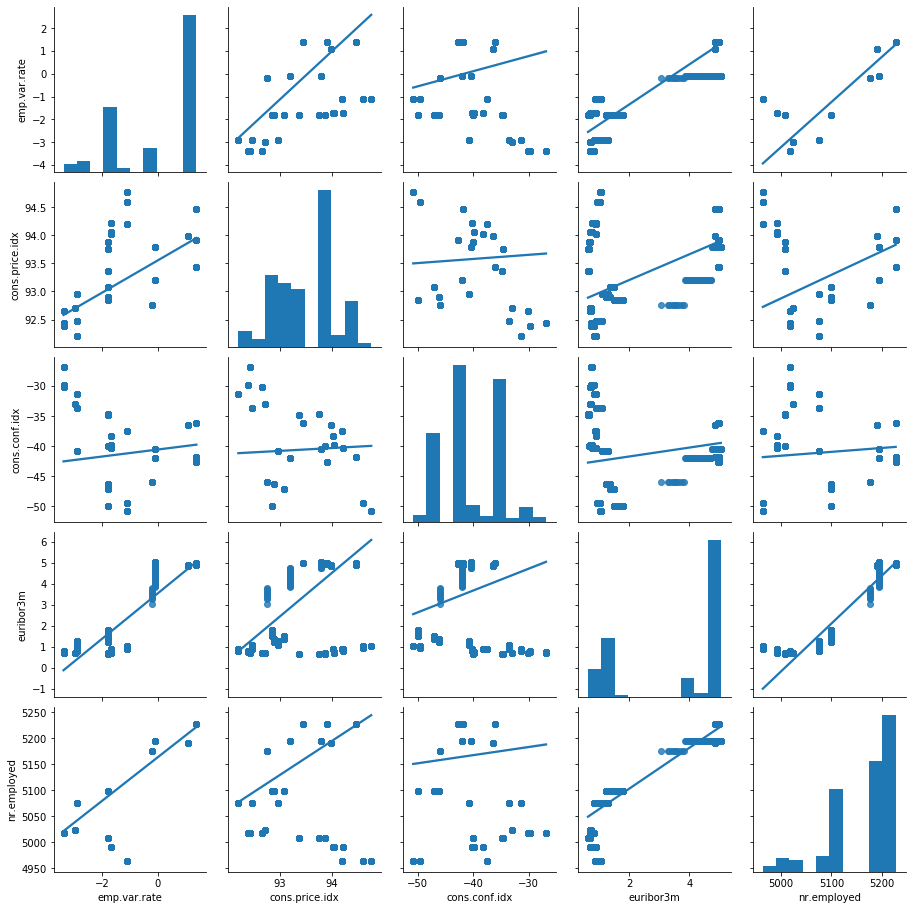

In [37]:
#Plot numerical variables in pairs
in_var = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
sns.pairplot(bank_full[in_var],kind='reg')
plt.show()

Employment variation rate is positively related to consumer price index, Europe's Libor 3 month rate and number of employees.

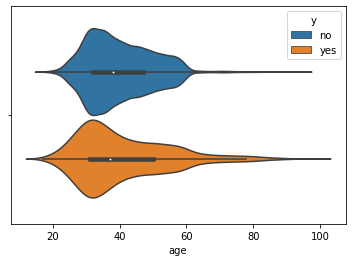

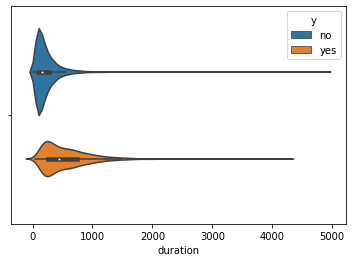

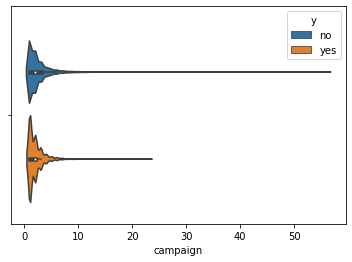

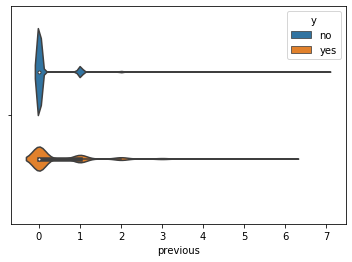

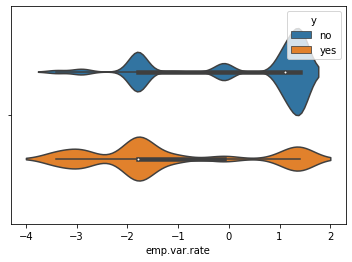

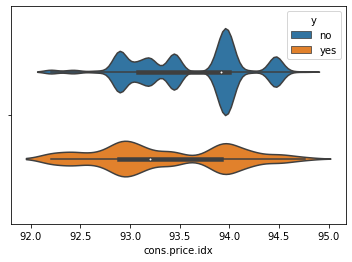

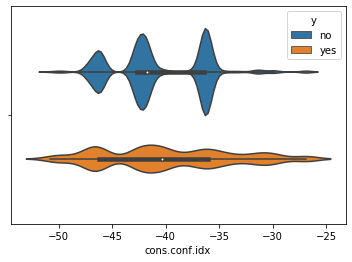

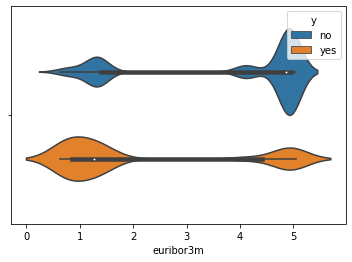

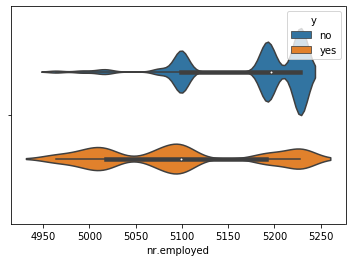

In [17]:
#Plot a box plot of numeric variable within subset of rows where label variable y ‘has the client subscribed a term deposit’ = ‘yes’ vs ‘no’
for var in num_columns:
    sns.violinplot( x=var, y=['']*len(bank_full), data = bank_full, hue ='y')
    plt.show()

The largest group of people is around 30 years old. Most clients are between 20 and 60 years old.
Most phone call duration is below 100 thousand seconds. People who subscribed the term tend to have longer duration over phone.
Most people have been contacted less than 9 times during this campaign.
Most people haven’t been contacted before.
When employment variation rate is around 1.5, more people are not willing to subscribe. When employment variation rate is around -1.9, more people will subscribe. 
When consumer price index is around 94, more people will not subscribe. And most people subscribed when consumer price index is at 92.9 and 94.0.
Consumers tend to not subscribe when the consumer confidential index is around -46, -43, and -36.
More people subscribe when  euribor 3 month rate is below 2, the peak is at 1, while more people don’t subscribe when euribor3m is above 4.
When number of employees is below 5050, more people subscribe. The number of subscribed clients reaches 3 peaks when quarterly number of employees reach 5010, 5090 5230, 

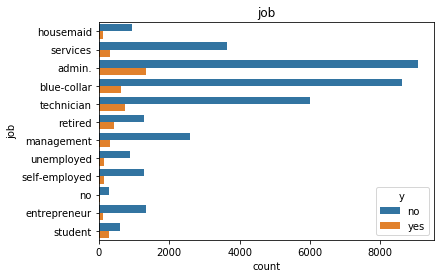

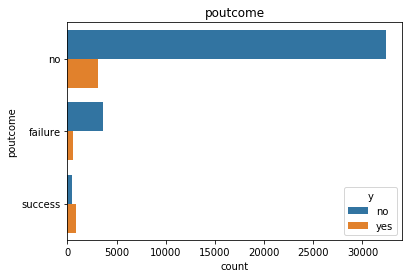

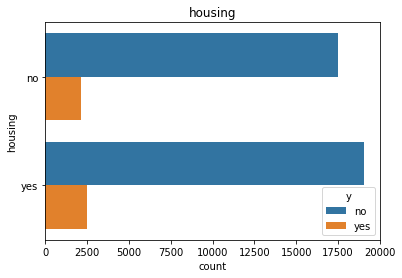

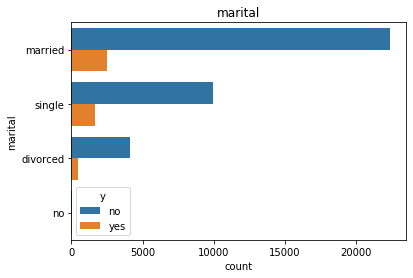

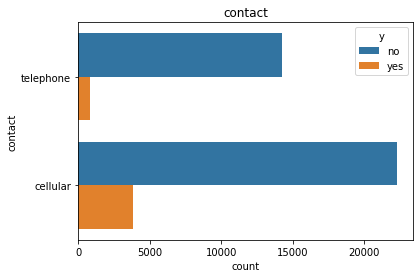

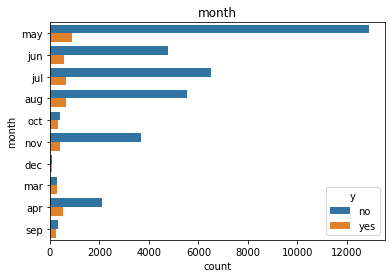

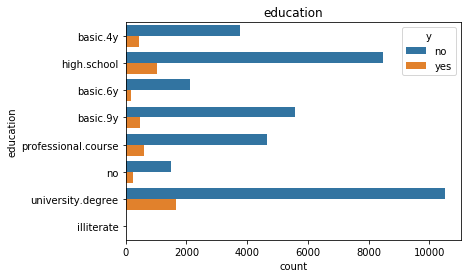

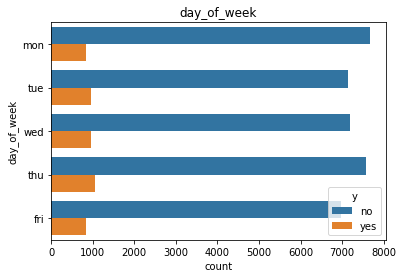

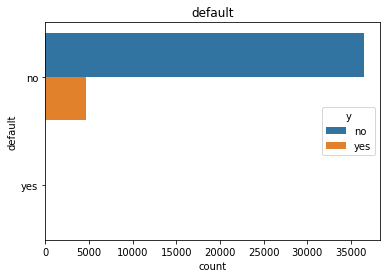

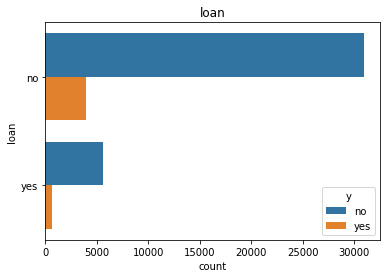

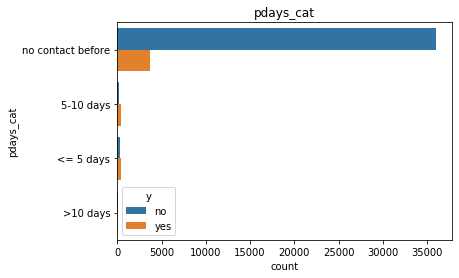

In [18]:
#Countplot for categorial variables
for var in cat_columns:
    sns.countplot(y=var,data = bank_full, hue ='y')
    plt.title(var)
    plt.show()

Observation 1.
Among people who subscribed the term, the largest number is from administrative job. The least number is from entrepreneur and housemaid. Students are more likely to subscribe than other occupations. 

Observation 2.
From the poutcome(previous outcome) count plot, there are more subscribed clients than unsubscribed clients, which means people are more likely to subscribe again if they did previously.

Observation 3.
From the pdays_cat (number of days that passed by after the client was last contacted from a previous campaign) plot, there are more subscribed clients than unsubscribed clients when there is a previous contact less than 10 days ago. 


In [19]:
#Create a corsstable to see the relationship between education and job. The table shows the degree holded by the percentage of clients in each position  
job_education = pd.crosstab(bank_full['job'], bank_full['education']).apply(lambda r: r/r.sum(), axis = 1)
job_education

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,no,professional.course,university.degree
job,,,,,,,,
admin.,0.007388,0.014489,0.047879,0.319420,0.000096,0.023892,0.034830,0.552005
blue-collar,0.250486,0.154096,0.391506,0.094878,0.000864,0.049060,0.048952,0.010158
entrepreneur,0.094093,0.048764,0.144231,0.160714,0.001374,0.039148,0.092720,0.418956
housemaid,0.447170,0.072642,0.088679,0.164151,0.000943,0.039623,0.055660,0.131132
management,0.034200,0.029070,0.056772,0.101915,0.000000,0.042066,0.030438,0.705540
no,0.157576,0.066667,0.093939,0.112121,0.000000,0.396970,0.036364,0.136364
retired,0.347093,0.043605,0.084302,0.160465,0.001744,0.056977,0.140116,0.165698
self-employed,0.065447,0.017593,0.154821,0.083040,0.002111,0.020408,0.118227,0.538353
services,0.033258,0.056941,0.097758,0.675737,0.000000,0.037793,0.054926,0.043588


In [20]:
#Drop unknown values and make contigency tables for default vs outcome y, housing vs outcome y, and loan vs outcome y
bank_full = bank_full[~bank_full['default'].str.contains("unknown")]
bank_full = bank_full[~bank_full['housing'].str.contains("unknown")]
bank_full = bank_full[~bank_full['loan'].str.contains("unknown")]
dflt_y = pd.crosstab(bank_full['default'], bank_full['y'],  dropna = True)
house_y = pd.crosstab(bank_full['housing'], bank_full['y'])
loan_y = pd.crosstab(bank_full['loan'], bank_full['y'])
print (dflt_y, '\n\n', house_y, '\n\n', loan_y)

y           no   yes
default             
no       36545  4640
yes          3     0 

 y           no   yes
housing             
no       17479  2133
yes      19069  2507 

 y        no   yes
loan             
no    30983  3957
yes    5565   683


In [21]:
# Run fisher’s exact test between default vs outcome y,  housing vs outcome y, and loan vs outcome y
con_tables = [dflt_y,house_y,loan_y]
names= [('dflt_oddsratio', 'dflt_pvalue'), ('house_oddsratio','house_pvalue'), ('loan_oddsratio', 'loan_pvalue')]
i=0
for t in con_tables:
    oddsratio, pvalue = stats.fisher_exact(t)
    print (names[i][0],':', oddsratio, names[i][1],':', pvalue)
    i+=1

dflt_oddsratio : 0.0 dflt_pvalue : 1.0
house_oddsratio : 1.0773384056424793 house_pvalue : 0.017706797460646316
loan_oddsratio : 0.9609769078692076 loan_pvalue : 0.3731669615484633


Having a house or not has effect on the outcome

In [22]:
#Apply principal components analysis to numerical variables
pca = PCA(n_components = 2)
pca.fit(bank_full[num_columns])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.92626125 0.07183167]
[52624.08039516 14654.66025625]


In [23]:
pca = PCA(n_components=0.8)
n_pca = pca.fit_transform(bank_full[num_columns])
print (bank_full[num_columns].shape, n_pca.shape)

(41188, 9) (41188, 1)


In [24]:
#Apply principal components analysis to one hot encoded data 
pca = PCA(n_components = 2)
pca.fit(ohe)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.11526411 0.09095436]
[159.00425034 141.245115  ]


In [25]:
pca = PCA(n_components=0.8)
c_pca = pca.fit_transform(ohe)
print (ohe.shape, c_pca.shape)

(41188, 54) (41188, 16)


# ANOVA Analysis

## For Numerical Variables

In [15]:
def anova_model(var):
    model = ols('Q("{var}")~C(y_yes)'.format(var = var), data=  imputed_bank_full).fit()
    print (var)
    print (sm.stats.anova_lm(model, typ=2),  '\n')

In [16]:
for var in num_columns:
    anova_model(var)

age
                sum_sq       df          F        PR(>F)
C(y_yes)  4.133451e+03      1.0  38.094659  6.802136e-10
Residual  4.468876e+06  41186.0        NaN           NaN 

duration
                sum_sq       df            F  PR(>F)
C(y_yes)  4.547710e+08      1.0  8094.101634     0.0
Residual  2.314055e+09  41186.0          NaN     NaN 

campaign
                 sum_sq       df           F        PR(>F)
C(y_yes)    1391.562959      1.0  182.156673  2.007780e-41
Residual  314635.259513  41186.0         NaN           NaN 

previous
               sum_sq       df            F  PR(>F)
C(y_yes)   534.485490      1.0  2304.257088     0.0
Residual  9553.326106  41186.0          NaN     NaN 

emp.var.rate
                sum_sq       df            F  PR(>F)
C(y_yes)   9046.842163      1.0  4023.829925     0.0
Residual  92599.152609  41186.0          NaN     NaN 

cons.price.idx
                sum_sq       df           F         PR(>F)
C(y_yes)    256.037173      1.0  778.589786  9.318

Reject null for all numerical variables. The mean of each numercial is different between the groups of positive outcome and negative outcome.

## For Categorical Variables

In [18]:
def melt_cat(var):
    melted = bank_full.melt(id_vars = [var], value_vars=['y'])
    melted_dummy= pd.get_dummies(melted, columns = ['value'])
    return melted_dummy
def anova_model2(var):
    model2 = ols('value_yes ~ C({var})'.format(var = var), data=melt_cat(var)).fit()
    print (var)
    print (sm.stats.anova_lm(model2, typ=2),  '\n')

In [26]:
for var in list(set(cat_columns)-set(['y'])):
    anova_model2(var)

pdays_cat
                   sum_sq       df           F  PR(>F)
C(pdays_cat)   436.191715      3.0  1626.70163     0.0
Residual      3681.092931  41184.0         NaN     NaN 

month
               sum_sq       df           F  PR(>F)
C(month)   310.000840      9.0  372.537812     0.0
Residual  3807.283806  41178.0         NaN     NaN 

job
               sum_sq       df          F         PR(>F)
C(job)      96.088879     11.0  89.447741  1.618353e-201
Residual  4021.195767  41176.0        NaN            NaN 

day_of_week
                     sum_sq       df         F   PR(>F)
C(day_of_week)     2.613532      4.0  6.539592  0.00003
Residual        4114.671114  41183.0       NaN      NaN 

default
                 sum_sq       df         F    PR(>F)
C(default)     0.038076      1.0  0.380882  0.537135
Residual    4117.246570  41186.0       NaN       NaN 

marital
                 sum_sq       df          F        PR(>F)
C(marital)    12.261003      3.0  41.003185  1.898385e-26
Residual  

For pdays_cat,month,job,marital,education,poutcome,contact variables, the P-values obtained from ANOVA analysis are significant (P<0.05), and therefore, we conclude that there are significant differences among these variables individually.

From ANOVA analysis, we know that differences between groups in these variables individually are statistically significant, but ANOVA does not tell which groups are significantly different from each other. To know the pairs of significant different groups, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

Here we only select some variables that we want to explore based on common sense.

## Job

In [27]:
df_job_dummy = melt_cat('job')

In [28]:
m_comp_job = pairwise_tukeyhsd(endog=df_job_dummy['value_yes'], groups=df_job_dummy['job'], alpha=0.05)
print(m_comp_job)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
       admin.   blue-collar  -0.0608  0.001 -0.0754 -0.0462   True
       admin.  entrepreneur  -0.0446  0.001 -0.0731  -0.016   True
       admin.     housemaid  -0.0297 0.1242 -0.0627  0.0032  False
       admin.    management  -0.0176 0.2345 -0.0389  0.0038  False
       admin.            no  -0.0176    0.9 -0.0747  0.0395  False
       admin.       retired   0.1226  0.001   0.096  0.1492   True
       admin. self-employed  -0.0249 0.1742 -0.0538   0.004  False
       admin.      services  -0.0483  0.001 -0.0674 -0.0293   True
       admin.       student   0.1846  0.001  0.1486  0.2205   True
       admin.    technician  -0.0215  0.001 -0.0374 -0.0055   True
       admin.    unemployed   0.0123    0.9 -0.0213  0.0459  False
  blue-collar  entrepreneur   0.0162  0.768 -0.0126   0.045  F

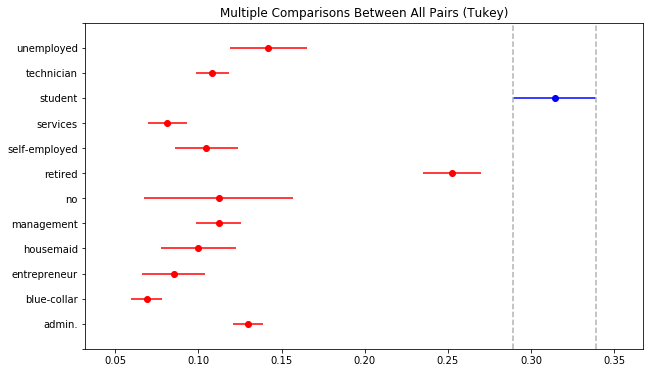

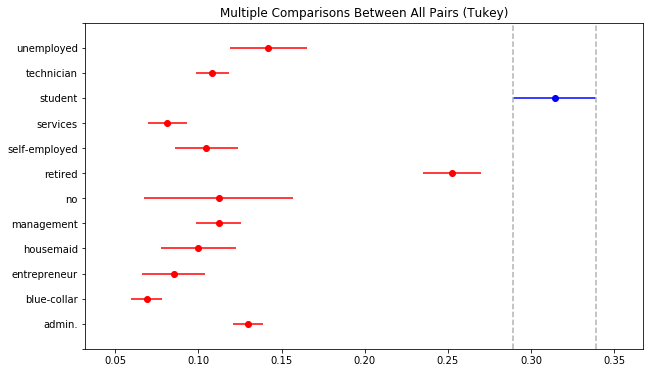

In [29]:
#Visualize significant differences in a plot with one confidence interval per group
m_comp_job.plot_simultaneous(comparison_name='student')

The mean for the group of student, and retired peopel are higher than other groups. It means that student and retired people are more likely to subscribe.

## Previous Outcome

In [30]:
df_po_dummy = melt_cat('poutcome')

In [31]:
m_comp_po = pairwise_tukeyhsd(endog=df_po_dummy['value_yes'], groups=df_po_dummy['poutcome'], alpha=0.05)
print(m_comp_po)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------
failure      no   -0.054 0.001 -0.0654 -0.0426   True
failure success   0.5088 0.001  0.4871  0.5306   True
     no success   0.5628 0.001  0.5435  0.5821   True
-----------------------------------------------------


The mean of three previous outcome groups are all significant different.

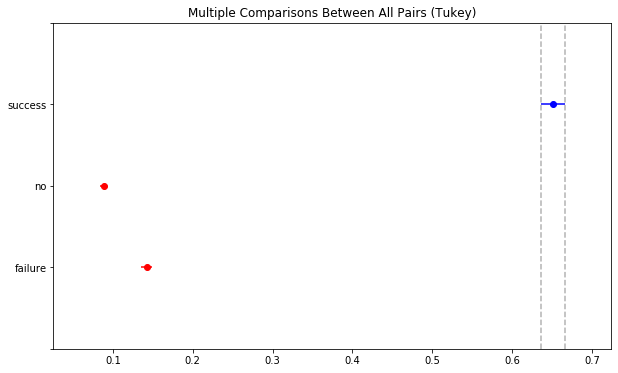

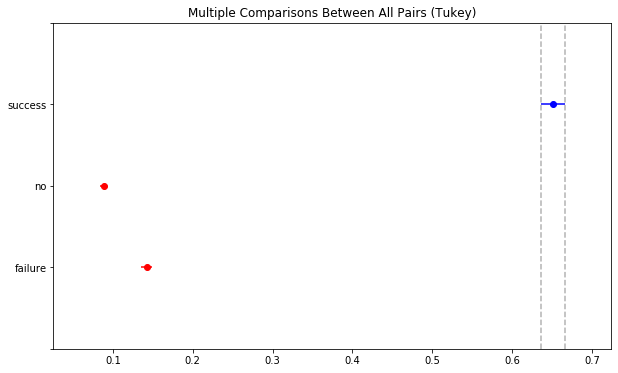

In [57]:
m_comp_po.plot_simultaneous(comparison_name="success")

Clients are more likely to subscribe if previous outcome is successful. 

## Month

In [32]:
df_month_dummy = melt_cat('month')

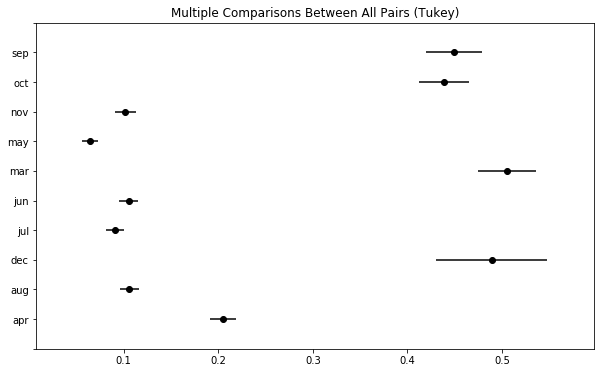

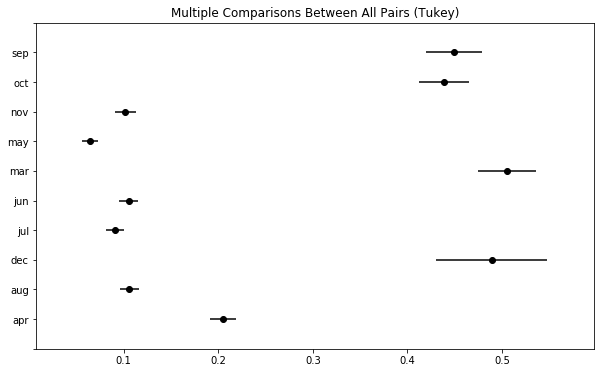

In [72]:
m_comp_month = pairwise_tukeyhsd(endog=df_month_dummy['value_yes'], groups=df_month_dummy['month'], alpha=0.05)
m_comp_month.plot_simultaneous()

The highest subscribe rates occur in March, August, September, October.

## Education

In [33]:
df_education_dummy = melt_cat('education')

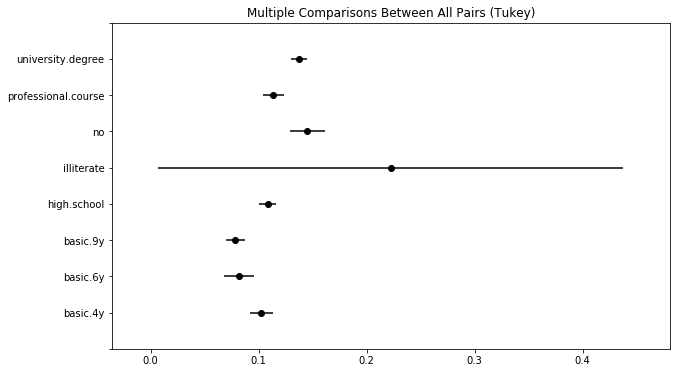

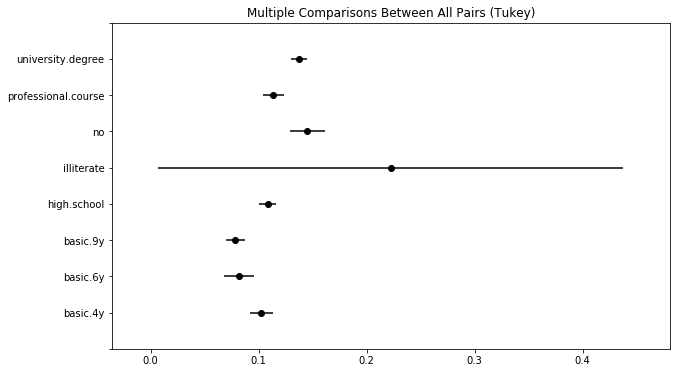

In [77]:
m_comp_edu = pairwise_tukeyhsd(endog=df_education_dummy['value_yes'], groups=df_education_dummy['education'], alpha=0.05)
m_comp_edu.plot_simultaneous()

Although the mean of illiterate group is high, it doesn't mean that the illiterate people are more likely to subscribe. The reason is that the confidence interval is too wide. We can also ignore 'no' group, that contains unknown values. People who get advanced education (high school, professional course, and university degree) are more likely to subscribe.

## Loan

In [80]:
df_loan_dummy = melt_cat('loan')
loan = ols('value_yes ~ C(loan)', data = df_loan_dummy).fit()
aov_tabel_loan=sm.stats.anova_lm(loan, typ =2)
print (aov_tabel_loan)

               sum_sq       df         F    PR(>F)
C(loan)      0.082124      1.0  0.821521  0.364741
Residual  4117.202522  41186.0       NaN       NaN


The result is not significant among people who have loans or not.

## Pday_Cat

In [34]:
df_pd_dummy = melt_cat('pdays_cat')

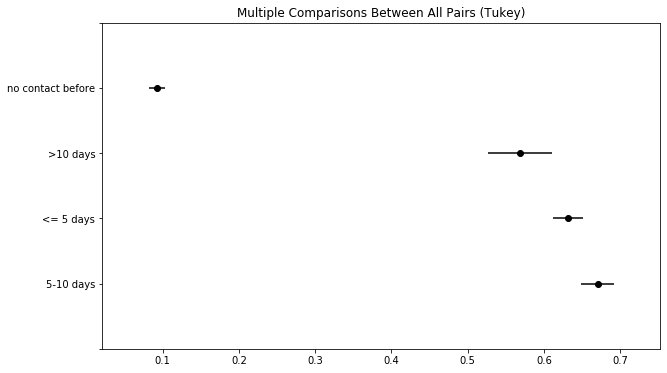

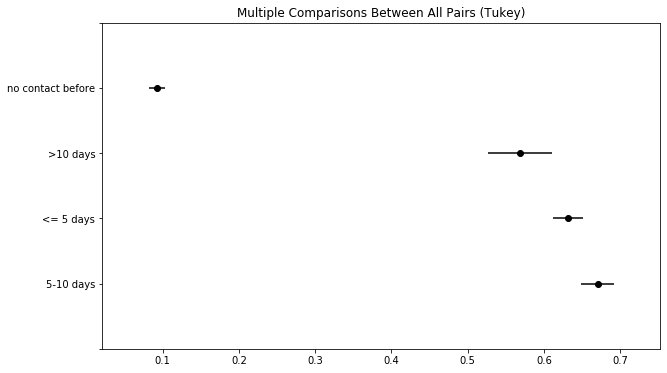

In [35]:
m_comp_pd= pairwise_tukeyhsd(endog=df_pd_dummy['value_yes'], groups=df_pd_dummy['pdays_cat'], alpha=0.05)
m_comp_pd.plot_simultaneous()

The group of 5-10 days that passed by after the client was last contacted from a previous campaign have the highest mean. The group of no contact before has the lowest mean. 

# Modeling

## Train/Test Split

In [15]:
# To have a realistic predictive model, duration variable is dropped from numeric columns.
num_columns.remove('duration')
imputed_bank_full= imputed_bank_full.drop(['duration', 'y_no'], axis = 1) 
imputed_bank_full

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,housing_no,housing_yes,...,day_of_week_wed,loan_no,loan_yes,y_yes,default_no,default_yes,pdays_cat_5-10 days,pdays_cat_<= 5 days,pdays_cat_>10 days,pdays_cat_no contact before
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,0,-1.1,94.767,-50.8,1.028,4963.6,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
41184,46,1,0,-1.1,94.767,-50.8,1.028,4963.6,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41185,56,2,0,-1.1,94.767,-50.8,1.028,4963.6,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41186,44,1,0,-1.1,94.767,-50.8,1.028,4963.6,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [16]:
#Divide dataset into trainX, trainY, testX, testY 
X_train, X_test, y_train, y_test = train_test_split(imputed_bank_full.drop(['y_yes'], axis = 1), imputed_bank_full['y_yes'], test_size=0.2, random_state=42)
print (X_train.shape)
print (X_test.shape)

(32950, 62)
(8238, 62)


In [17]:
#Standardization,mean removal and variance scaling on the train set for numeric training data
X_train_df = pd.DataFrame(data = X_train, columns = imputed_bank_full.drop(['y_yes'], axis = 1).columns)
X_train_df_num = X_train_df[num_columns]
scaler = preprocessing.StandardScaler().fit(X_train_df_num)
X_train_scaled_num = scaler.transform(X_train_df_num)
X_train_df[num_columns] = X_train_scaled_num
print (X_train_df.shape)

(32950, 62)


In [18]:
#smote for imbalanced data on training dataset 
X_train_smote = X_train_df.values
y_train_smote = y_train.values
sm = SMOTE(random_state=42)
X_res_train, y_res_train = sm.fit_resample(X_train_smote, y_train_smote)
X_res_train.shape, y_res_train.shape

((58490, 62), (58490,))

In [19]:
##Standardization,mean removal and variance scaling on the train set for numeric testing data
X_test_df = pd.DataFrame(data = X_test, columns = imputed_bank_full.drop(['y_yes'], axis = 1).columns)
X_test_df_num = X_test_df[num_columns]
X_test_scaled_num = scaler.transform(X_test_df_num)
X_test_df[num_columns] = X_test_scaled_num
print (X_test_df.shape)
X_test_df[num_columns]

(8238, 62)


,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
32884,1.627357,-0.566200,1.677559,-1.199440,-1.180760,-1.229916,-1.340304,-0.939748
3169,1.435707,-0.206242,-0.350902,0.647709,0.720307,0.890097,0.713674,0.330405
32206,-0.672445,-0.566200,1.677559,-1.199440,-1.180760,-1.229916,-1.332229,-0.939748
9403,-0.384970,0.513676,-0.350902,0.838794,1.533570,-0.278074,0.775391,0.843165
14020,-1.247395,-0.206242,-0.350902,0.838794,0.589080,-0.472769,0.773084,0.843165
...,...,...,...,...,...,...,...,...
12322,-1.247395,-0.566200,-0.350902,0.838794,0.589080,-0.472769,0.770777,0.843165
23440,0.094156,1.593552,-0.350902,0.838794,-0.229363,0.954995,0.773661,0.843165
29431,0.573281,3.393346,1.677559,-1.199440,-0.866505,-1.424611,-1.279164,-0.939748
16627,-0.864095,-0.206242,-0.350902,0.838794,0.589080,-0.472769,0.773084,0.843165


# Random Forest Model

In [49]:
clf = RandomForestClassifier(max_depth=None, random_state=42, n_estimators =125, max_features= 'sqrt') 
clf.fit(X_res_train, y_res_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
y_predict = clf.predict(X_test_df)
print(y_predict)
np.unique(y_predict, return_counts=True)

[0. 0. 0. ... 0. 0. 0.]


(array([0., 1.]), array([7569,  669], dtype=int64))

In [51]:
#Predict class probabilities for X_test
rf_probs = clf.predict_proba(X_test_df)[:,1]
print ('rf_probs: ', rf_probs)
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
roc_value = metrics.roc_auc_score(y_test, rf_probs)
print ('roc_value: ', roc_value)
# Model Accuracy, how often is the classifier correct?
base_score= clf.score(X_test_df, y_test)
print ('Base Score: ', base_score)

rf_probs:  [0.032      0.024      0.016      ... 0.144      0.07733333 0.192     ]
roc_value:  0.7741799758505222
Base Score:  0.8844379703811605


# Use Randomsearch for Best Parameters 

In [53]:
#Create a random forest and examine the default values
# Get default hyperparameters
rf = RandomForestClassifier(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [54]:
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)

# Number of features to consider at every split
max_features = ['auto', 'sqrt']


# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 250, 300]}


In [55]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_res_train, y_res_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [46]:
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 65,
 'bootstrap': False}

In [56]:
best_random = rf_random.best_estimator_
print (best_random)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=65, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [57]:
best_y_predict = best_random.predict(X_test_df)
best_rf_probs = best_random.predict_proba(X_test_df)[:,1]
print ('best_random rf_probs: ', best_rf_probs)
best_roc_value=metrics.roc_auc_score(y_test, best_rf_probs)
print ('best_random rf_probs: ', best_roc_value)
best_score = best_random.score(X_test_df, y_test)
print ('best_random score: ', best_score)

best_random rf_probs:  [0.08166667 0.01333333 0.00166667 ... 0.14111111 0.01888889 0.25666667]
best_random rf_probs:  0.772181602901452
best_random score:  0.8885651857246905


In [58]:
print('Improvement of {:0.2f}%.'.format( 100 * (best_score - base_score) / base_score))

Improvement of 0.47%.


In [118]:
#Generate confusion matrix for best_random
tn, fp, fn, tp = metrics.confusion_matrix(y_test, best_y_predict).ravel()
print ('true negative:',tn,'\n','false posotive:',fp,'\n', 'false negative:', fn, '\n','true positive:', tp)

true negative: 6984 
 false posotive: 319 
 false negative: 599 
 true positive: 336


Text(0.5, 1.0, 'Confusion Matrix')

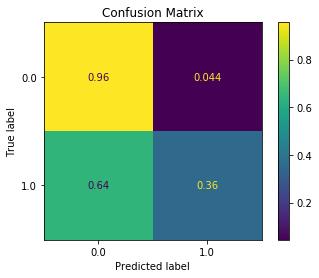

In [119]:
cm = metrics.plot_confusion_matrix(best_random, X_test_df, y_test,normalize = 'true')
cm.ax_.set_title('Confusion Matrix')                              

In [127]:
#Plot ROC curve for best_random
fpr, tpr, threshold = metrics.roc_curve(y_test, best_rf_probs, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)

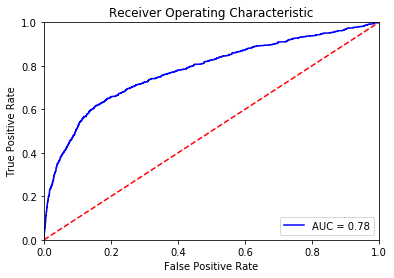

In [128]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Grid Search with Cross Validation

In [59]:
# Create a parameter grid based on the best_estimator from random search result
param_grid = {
'n_estimators': [30, 50, 70, 100, 200],
 'min_samples_split':[4, 5, 6],
 'min_samples_leaf': [1,2,3],
 'max_features': ['sqrt','auto'],
 'max_depth': [50, 100, 200, None],
 'bootstrap': [False]
}
pprint(param_grid)

{'bootstrap': [False],
 'max_depth': [50, 100, 200, None],
 'max_features': ['sqrt', 'auto'],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [4, 5, 6],
 'n_estimators': [30, 50, 70, 100, 200]}


In [60]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)   
# Fit the grid search to the data
grid_search.fit(X_res_train, y_res_train)
# Find the best prameters
grid_search.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 73.3min finished


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [61]:
best_grid = grid_search.best_estimator_
best_grid_predict = best_grid.predict(X_test_df)

In [62]:
grid_rf_probs = best_grid.predict_proba(X_test_df)[:,1]
print ('best grid rf_probs: ',grid_rf_probs)
grid_roc_value=metrics.roc_auc_score(y_test, grid_rf_probs)
print ('best grid rf_probs: ', grid_roc_value)
grid_score = best_grid.score(X_test_df, y_test)
print ('best grid score: ', grid_score)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_score - base_score) / base_score))

best grid rf_probs:  [0.07666667 0.01125    0.0025     ... 0.14958333 0.0225     0.25916667]
best grid rf_probs:  0.7718380330111205
best grid score:  0.8879582422918184
Improvement of 0.40%.


By comparing the result of random search and grid search, grid search improves0.4% from the base model, while random search improves 0.47%. Random search is performing a little better.Hence, we select random search with selected important features to predict if a client will subscribe or not.

In [64]:
feature_importances = pd.DataFrame(best_random.feature_importances_, index =imputed_bank_full.drop(['y_yes'], axis = 1).columns, columns = ['Importance']).sort_values(by='Importance', ascending=False)
feature_importances = feature_importances[:30]
print (feature_importances)

                             Importance
euribor3m                      0.117019
campaign                       0.083187
nr.employed                    0.068614
age                            0.063486
emp.var.rate                   0.050788
contact_telephone              0.026289
cons.conf.idx                  0.025931
day_of_week_mon                0.025623
job_admin.                     0.024436
cons.price.idx                 0.023918
day_of_week_thu                0.023580
day_of_week_fri                0.023238
day_of_week_tue                0.022988
day_of_week_wed                0.022123
education_university.degree    0.020205
job_blue-collar                0.019802
contact_cellular               0.018786
pdays_cat_no contact before    0.018503
housing_yes                    0.018113
marital_married                0.017662
housing_no                     0.017587
education_high.school          0.017163
poutcome_success               0.016042
month_may                      0.014896


[Text(0, 0, 'euribor3m'),
 Text(0, 0, 'campaign'),
 Text(0, 0, 'nr.employed'),
 Text(0, 0, 'age'),
 Text(0, 0, 'emp.var.rate'),
 Text(0, 0, 'contact_telephone'),
 Text(0, 0, 'cons.conf.idx'),
 Text(0, 0, 'day_of_week_mon'),
 Text(0, 0, 'job_admin.'),
 Text(0, 0, 'cons.price.idx'),
 Text(0, 0, 'day_of_week_thu'),
 Text(0, 0, 'day_of_week_fri'),
 Text(0, 0, 'day_of_week_tue'),
 Text(0, 0, 'day_of_week_wed'),
 Text(0, 0, 'education_university.degree'),
 Text(0, 0, 'job_blue-collar'),
 Text(0, 0, 'contact_cellular'),
 Text(0, 0, 'pdays_cat_no contact before'),
 Text(0, 0, 'housing_yes'),
 Text(0, 0, 'marital_married'),
 Text(0, 0, 'housing_no'),
 Text(0, 0, 'education_high.school'),
 Text(0, 0, 'poutcome_success'),
 Text(0, 0, 'month_may'),
 Text(0, 0, 'marital_single'),
 Text(0, 0, 'education_basic.9y'),
 Text(0, 0, 'loan_no'),
 Text(0, 0, 'job_technician'),
 Text(0, 0, 'loan_yes'),
 Text(0, 0, 'marital_divorced')]

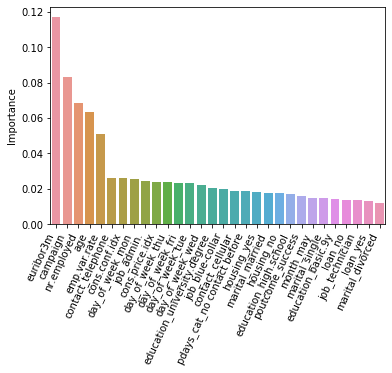

In [65]:
#plot feature importance
feature_importances
ax = sns.barplot(x=feature_importances.index, y =feature_importances.Importance)
ax.set_xticklabels(ax.get_xticklabels(), rotation=65, horizontalalignment='right')

From above feature importance table and chart, we can see that  Europe's Libor rate ('euribor3m'),  client's age ('age'), number of employees (nr.employed), number of contacts performed during this campaign and for a client  ('campaign'), employment variation rate ('emp.var.rate'), contact on Monday (day_of_week_mon), client who has university degree (education_university_degree), client who doesn't own a house (housing_no), consumer confidential index (cons.conf.idx),  client who owns a house (housing_yes) are the imporatant features that drive the decision of the customer to subscribe the term deposit.

In [69]:
#Generate confusion matrix for best_random 
tn, fp, fn, tp = metrics.confusion_matrix(y_test, best_y_predict).ravel()
print ('true negative:',tn,'\n','false posotive:',fp,'\n', 'false negative:', fn, '\n','true positive:', tp)

true negative: 7014 
 false posotive: 289 
 false negative: 629 
 true positive: 306


Text(0.5, 1.0, 'Confusion Matrix')

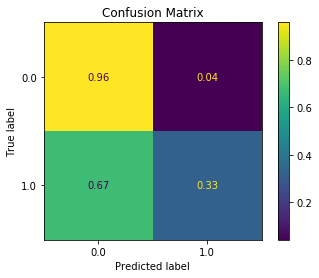

In [70]:
cm = metrics.plot_confusion_matrix(best_random , X_test_df, y_test,normalize = 'true')
cm.ax_.set_title('Confusion Matrix')                              

In [116]:
#Plot ROC curve for best_random
fpr_grid, tpr_grid, threshold_grid = metrics.roc_curve(y_test, best_rf_probs, pos_label = 1)
roc_auc = metrics.auc(fpr_grid, tpr_grid)

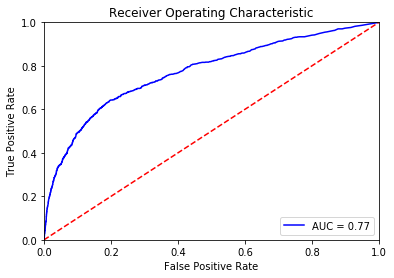

In [79]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_grid, tpr_grid, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Logistic Regression

In [80]:
clf2 = LogisticRegression(random_state=42).fit(X_res_train, y_res_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [81]:
y_predict2 = clf2.predict(X_test_df)

In [83]:
#Predict class probabilities for X_test
lg_probs2 = clf2.predict_proba(X_test_df)[:,1]
print ('rf_probs: ', lg_probs2)
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
lg_value2 = metrics.roc_auc_score(y_test, lg_probs2)
print ('roc_value: ', lg_value2)
# Model Accuracy, how often is the classifier correct?
base_score_logistic = clf2.score(X_test_df, y_test)
print ('Score: ', base_score_logistic)

rf_probs:  [0.27884685 0.11014962 0.37189129 ... 0.27196325 0.47649192 0.23955233]
roc_value:  0.773518464684867
Score:  0.8184025248846808


## Randomsearch for Best Parameters 

In [84]:
print('Parameters currently in use:\n')
pprint(clf2.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [103]:
# Create regularization hyperparameter distribution using uniform distribution
C = [0,1,2,3]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}, 'balanced', 'None']
penalty = ['l1', 'l2']

In [104]:
random_grid_logistic = {'C': C,
               'penalty': penalty,
               'class_weight': class_weight
              }
print (random_grid_logistic)

{'C': [0, 1, 2, 3], 'penalty': ['l1', 'l2'], 'class_weight': [{1: 0.5, 0: 0.5}, {1: 0.4, 0: 0.6}, {1: 0.6, 0: 0.4}, {1: 0.7, 0: 0.3}, 'balanced', 'None']}


In [105]:
random_logistic = RandomizedSearchCV(estimator = clf2, param_distributions = random_grid_logistic, n_iter = 50, cv = 5, random_state=42, verbose=0, n_jobs=-1)
# Fit the random search model
random_logistic.fit(X_res_train, y_res_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0, 1, 2, 3],
                                        'class_weight': [{0: 0.5, 1: 0.5},
                                                         {0: 0.6, 1: 0.4},
                                                         {0: 0.4, 1: 0.6},
 

In [106]:
random_logistic.best_params_

{'penalty': 'l2', 'class_weight': 'balanced', 'C': 1}

In [107]:
best_random_logistic = random_logistic.best_estimator_
print (best_random_logistic)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [108]:
best_y_predict_logistic = best_random_logistic.predict(X_test_df)
best_probs_logistic = best_random_logistic.predict_proba(X_test_df)[:,1]
print ('best_random rf_probs_logistic: ', best_probs_logistic)
best_roc_value_logistic=metrics.roc_auc_score(y_test, best_probs_logistic)
print ('best_random rf_probs_logistic: ', best_roc_value_logistic)
best_score_logistic = best_random_logistic.score(X_test_df, y_test)
print ('best_random score_logistic: ', best_score_logistic)
print('Improvement of {:0.2f}%.'.format( 100 * (best_score_logistic- base_score_logistic) / base_score_logistic))

best_random rf_probs_logistic:  [0.27884685 0.11014962 0.37189129 ... 0.27196325 0.47649192 0.23955233]
best_random rf_probs_logistic:  0.773518464684867
best_random score_logistic:  0.8184025248846808
Improvement of 0.00%.


## Grid Search with Cross Validation

In [109]:
param_grid_logistic = {
'C': [1.0,2.5,3.5,4.5],
'class_weight':  [{1:0.6, 0:0.4}, {1:0.3, 0:0.7}, {1:0.4, 0:0.6}, {1:0.7, 0:0.3}, 'balanced', 'None'],
'penalty': ['l2', 'l1']
}
pprint(param_grid_logistic)

{'C': [1.0, 2.5, 3.5, 4.5],
 'class_weight': [{0: 0.4, 1: 0.6},
                  {0: 0.7, 1: 0.3},
                  {0: 0.6, 1: 0.4},
                  {0: 0.3, 1: 0.7},
                  'balanced',
                  'None'],
 'penalty': ['l2', 'l1']}


In [110]:
# Instantiate the grid search model
grid_search_logistic = GridSearchCV(estimator =best_random_logistic, param_grid = param_grid_logistic, cv = 5, n_jobs = -1, verbose = 2)   
# Fit the grid search to the data
grid_search_logistic.fit(X_res_train, y_res_train)
# Find the best prameters
grid_search_logistic.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   35.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 4.5, 'class_weight': 'balanced', 'penalty': 'l2'}

In [111]:
best_grid_logistic = grid_search_logistic.best_estimator_
best_grid_predict_logistic = grid_search_logistic.predict(X_test_df)

In [112]:
grid_log_probs = best_grid_logistic.predict_proba(X_test_df)[:,1]
print ('best grid of logistic regression rf_probs: ',grid_log_probs)
grid_roc_value_log=metrics.roc_auc_score(y_test, grid_log_probs)
print ('best grid rf_probs: ', grid_roc_value_log)
grid_score_log = best_grid_logistic.score(X_test_df, y_test)
print ('best grid score: ', grid_score_log)
print('Improvement of {:0.2f}%.'.format( 100 * (best_score_logistic- base_score_logistic) / base_score_logistic))

best grid of logistic regression rf_probs:  [0.27870993 0.10962607 0.37117332 ... 0.27117487 0.47657286 0.23979476]
best grid rf_probs:  0.7734743834670538
best grid score:  0.8180383588249576
Improvement of 0.00%.


In [113]:
#Generate confusion matrix for best_grid_logistic 
tn, fp, fn, tp = metrics.confusion_matrix(y_test, best_grid_predict_logistic).ravel()
print ('true negative:',tn,'\n','false posotive:',fp,'\n', 'false negative:', fn, '\n','true positive:', tp)

true negative: 6180 
 false posotive: 1123 
 false negative: 376 
 true positive: 559


Text(0.5, 1.0, 'Confusion Matrix')

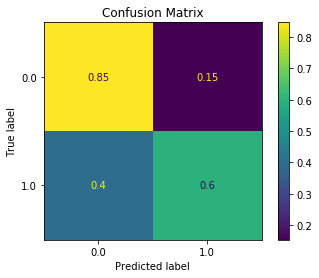

In [115]:
cm2 = metrics.plot_confusion_matrix(best_grid_logistic , X_test_df, y_test,normalize = 'true')
cm2.ax_.set_title('Confusion Matrix')                              

In [117]:
#Plot ROC curve for best_grid
fpr_grid, tpr_grid, threshold_grid = metrics.roc_curve(y_test, best_rf_probs, pos_label = 1)
roc_auc2 = metrics.auc(fpr_grid, tpr_grid)

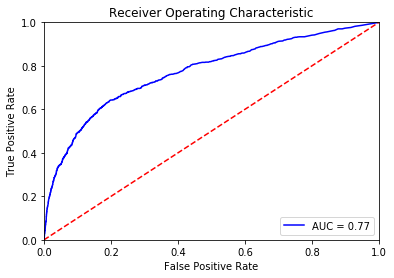

In [118]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_grid, tpr_grid, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Gradient Boosting Classifier

In [119]:
clf3 = GradientBoostingClassifier(random_state=0).fit(X_res_train, y_res_train)
y_predict3 = clf3.predict(X_test_df)

In [123]:
#Predict class probabilities for X_test
rf_probs3 = clf3.predict_proba(X_test_df)[:,1]
print ('rf_probs: ', rf_probs3)
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
roc_value3 = metrics.roc_auc_score(y_test, rf_probs3)
print ('roc_value: ', roc_value3)
# Model Accuracy, how often is the classifier correct?
base_score_gradient = clf3.score(X_test_df, y_test)
print ('Score: ',base_score_gradient)

rf_probs:  [0.10326616 0.11281044 0.29937424 ... 0.11243723 0.2189394  0.12336963]
roc_value:  0.7754884264835856
Score:  0.8798252002913328


In [124]:
print('Parameters currently in use:\n')
pprint(clf3.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


## Hyperparameter Tuning Using Random Search

In [125]:
learning_rate = [0.1, 0.2]
min_samples_split = [1,2]
min_samples_leaf = [1,2]
max_depth = [3,5]
max_features = ['sqrt','None']
n_estimators = [50, 100, 200]

In [126]:
random_grid_gradient = {'learning_rate':learning_rate,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                        'max_depth': max_depth,
                        'max_features': max_features,
                        'n_estimators': n_estimators}
pprint (random_grid_gradient)

{'learning_rate': [0.1, 0.2],
 'max_depth': [3, 5],
 'max_features': ['sqrt', 'None'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [1, 2],
 'n_estimators': [50, 100, 200]}


In [127]:
random_gradient = RandomizedSearchCV(estimator = clf3, param_distributions = random_grid_gradient, n_iter = 50, cv =5, random_state=42, verbose=0, n_jobs=-1)
# Fit the random search model
random_gradient.fit(X_res_train, y_res_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [128]:
best_random_gradient  = random_gradient.best_estimator_
print (best_random_gradient)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [129]:
best_y_predict_gradient = best_random_gradient.predict(X_test_df)
best_probs_gradient = best_random_gradient.predict_proba(X_test_df)[:,1]
print ('best_random rf_probs_gradient: ', best_probs_gradient)
best_roc_value_gradient=metrics.roc_auc_score(y_test, best_probs_gradient)
print ('best_random rf_probs_logistic: ', best_roc_value_gradient)
best_score_gradient = best_random_gradient.score(X_test_df, y_test)
print ('best_random score_logistic: ', best_score_gradient)
print('Improvement of {:0.2f}%.'.format( 100 * (random_gradient.best_score_- base_score_gradient) / base_score_gradient))

best_random rf_probs_gradient:  [0.07510628 0.0184778  0.16817242 ... 0.00514556 0.11886164 0.06127061]
best_random rf_probs_logistic:  0.7715027375022058
best_random score_logistic:  0.8929351784413693
Improvement of 4.45%.


##  Grid Search with Cross Validation

In [130]:
param_grid_gradient = {'learning_rate':learning_rate,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                        'max_depth': max_depth,
                        'max_features': max_features,
                        'n_estimators': n_estimators}
pprint (param_grid_gradient)

{'learning_rate': [0.1, 0.2],
 'max_depth': [3, 5],
 'max_features': ['sqrt', 'None'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [1, 2],
 'n_estimators': [50, 100, 200]}


In [131]:
# Instantiate the grid search model
grid_search_gradient = GridSearchCV(estimator = clf3, param_grid = param_grid_gradient, cv = 5, n_jobs = -1, verbose = 2)   
# Fit the grid search to the data
grid_search_gradient.fit(X_res_train, y_res_train)
# Find the best prameters
grid_search_gradient.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.8min finished


{'learning_rate': 0.2,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [132]:
best_grid_gradient = grid_search_gradient.best_estimator_
best_grid_predict_gradient = grid_search_gradient.predict(X_test_df)

In [133]:
grid_gradient_probs = best_grid_gradient.predict_proba(X_test_df)[:,1]
print ('best grid of logistic regression rf_probs: ',grid_gradient_probs)
grid_roc_value_gradient=metrics.roc_auc_score(y_test, grid_gradient_probs)
print ('best grid rf_probs: ', grid_roc_value_gradient)
grid_score_gradient= best_grid_gradient.score(X_test_df, y_test)
print ('best grid score: ', grid_score_gradient)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_score_gradient- base_score_gradient) / base_score_gradient))

best grid of logistic regression rf_probs:  [0.07510628 0.0184778  0.16817242 ... 0.00514556 0.11886164 0.06127061]
best grid rf_probs:  0.7715027375022058
best grid score:  0.8929351784413693
Improvement of 1.49%.


For the Gradient Boosting Classifier model, random search generate higher accuracy score. 

In [135]:
feature_importances2 = pd.DataFrame(best_random_gradient.feature_importances_, index =imputed_bank_full.drop(['y_yes'], axis = 1).columns, columns = ['Importance']).sort_values(by='Importance', ascending=False)
feature_importances2 = feature_importances2[:30]
print (feature_importances2)

                               Importance
nr.employed                      0.201255
campaign                         0.121507
cons.conf.idx                    0.047813
emp.var.rate                     0.046011
euribor3m                        0.044127
day_of_week_mon                  0.031197
day_of_week_wed                  0.029373
day_of_week_thu                  0.028267
job_admin.                       0.025440
education_university.degree      0.022215
day_of_week_fri                  0.021860
loan_yes                         0.020493
contact_telephone                0.019063
education_high.school            0.018584
poutcome_success                 0.017115
pdays_cat_5-10 days              0.017015
marital_single                   0.015408
job_blue-collar                  0.015195
housing_no                       0.014937
education_basic.9y               0.014844
cons.price.idx                   0.014544
day_of_week_tue                  0.014240
education_basic.4y               0

[Text(0, 0, 'nr.employed'),
 Text(0, 0, 'campaign'),
 Text(0, 0, 'cons.conf.idx'),
 Text(0, 0, 'emp.var.rate'),
 Text(0, 0, 'euribor3m'),
 Text(0, 0, 'day_of_week_mon'),
 Text(0, 0, 'day_of_week_wed'),
 Text(0, 0, 'day_of_week_thu'),
 Text(0, 0, 'job_admin.'),
 Text(0, 0, 'education_university.degree'),
 Text(0, 0, 'day_of_week_fri'),
 Text(0, 0, 'loan_yes'),
 Text(0, 0, 'contact_telephone'),
 Text(0, 0, 'education_high.school'),
 Text(0, 0, 'poutcome_success'),
 Text(0, 0, 'pdays_cat_5-10 days'),
 Text(0, 0, 'marital_single'),
 Text(0, 0, 'job_blue-collar'),
 Text(0, 0, 'housing_no'),
 Text(0, 0, 'education_basic.9y'),
 Text(0, 0, 'cons.price.idx'),
 Text(0, 0, 'day_of_week_tue'),
 Text(0, 0, 'education_basic.4y'),
 Text(0, 0, 'housing_yes'),
 Text(0, 0, 'age'),
 Text(0, 0, 'marital_divorced'),
 Text(0, 0, 'job_management'),
 Text(0, 0, 'marital_married'),
 Text(0, 0, 'job_technician'),
 Text(0, 0, 'education_professional.course')]

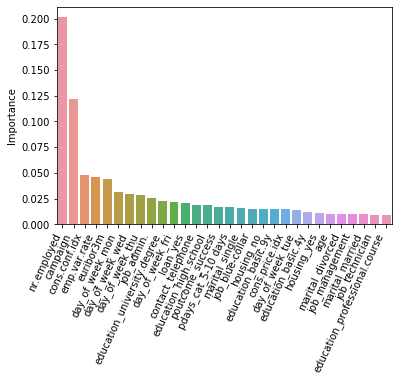

In [136]:
#plot feature importance
ax = sns.barplot(x=feature_importances2.index, y =feature_importances2.Importance)
ax.set_xticklabels(ax.get_xticklabels(), rotation=65, horizontalalignment='right')

In [137]:
#Generate confusion matrix for random_gradient
tn, fp, fn, tp = metrics.confusion_matrix(y_test, best_y_predict_gradient).ravel()
print ('true negative:',tn,'\n','false posotive:',fp,'\n', 'false negative:', fn, '\n','true positive:', tp)

true negative: 7062 
 false posotive: 241 
 false negative: 641 
 true positive: 294


Text(0.5, 1.0, 'Confusion Matrix')

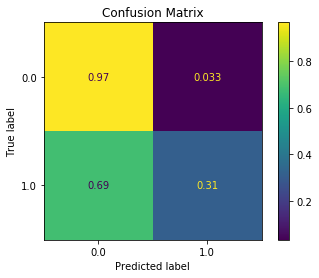

In [139]:
cm = metrics.plot_confusion_matrix(best_random_gradient, X_test_df, y_test,normalize = 'true')
cm.ax_.set_title('Confusion Matrix')                              